# スポーツジムのデータ分析

### 依頼事項
- 私の経営するスポーツジムでは、これまで会員数を増やしてきましたが、ここ一年、なんとなく会員数が伸び悩んでいる気がします。データ分析をしたことがないので、どのような会員が定着しているのかなどを把握できていないのが現状です。データ分析によって傾向をつかむことはできますか？<br>

### ヒアリング調査結果
- 本ジムには、いつでも利用できるオールタイム会員、日中だけ利用できるデイタイム会員、夜のみ利用できるナイト会員の３種類の会員区分が存在します。
- 通常、入会費が必要ですが、不定期に入会費半額キャンペーンや入会費無料キャンペーンを実施し、新規会員獲得を行なっています。
- 退会については、月末までに申請すると翌月末に退会することができます。例：3月19日退会申請　→　4月30日退会(=end_date)

### 依頼主から入手できたデータ
- use_log.csv：会員の利用履歴。期間（2018年4月〜2019年3月）
- customer_gym.csv：2019年3月31日時点でのすべての会員データ。ただし、2018年1月1日〜2018年12月31日の期間に退会した会員データも含まれている。
- class_gym.csv：会員区分データ（オールタイム、デイタイム、ナイトタイム）
- campaign_gym：キャンペーン区分データ（入会金：通常、半額キャンペーン、無料キャンペーン）


In [4]:
!pip install japanize-matplotlib
import japanize_matplotlib

## 1.会員情報のデータ分析

In [64]:
import pandas as pd
import numpy as np
#データを読み込む
pd.set_option('display.max_rows', 10)
              
campaign_gym = pd.read_csv('./data/campaign_gym.csv', encoding='UTF-8')
class_gym = pd.read_csv('./data/class_gym.csv', encoding='UTF-8')
customer_gym = pd.read_csv('./data/customer_gym.csv', encoding='UTF-8')
use_log = pd.read_csv('./data/use_log.csv', encoding='UTF-8')

### A.データの欠損、データのデータの欠損、データの揺れをチェック・補完する

In [6]:
#キャンペーンデータの確認
print(len(campaign_gym))
campaign_gym.isnull()

3


,campaign_id,campaign_name
0,False,False
1,False,False
2,False,False


In [7]:
campaign_gym

,campaign_id,campaign_name
0,CA1,通常
1,CA2,入会費半額
2,CA3,入会費無料


In [8]:
#データの型
pd.set_option('display.max_rows', None)
customer_gym.dtypes

customer_id    object
name           object
class          object
gender         object
start_date     object
end_date       object
campaign_id    object
is_deleted      int64
dtype: object

In [9]:
customer_gym['start_date'] = pd.to_datetime(customer_gym['start_date'])
customer_gym['end_date'] = pd.to_datetime(customer_gym['end_date'])
customer_gym.dtypes

customer_id            object
name                   object
class                  object
gender                 object
start_date     datetime64[ns]
end_date       datetime64[ns]
campaign_id            object
is_deleted              int64
dtype: object

In [10]:
print(len(class_gym))
class_gym.isnull()

3


,class,class_name,price
0,False,False,False
1,False,False,False
2,False,False,False


In [11]:
class_gym

,class,class_name,price
0,C01,オールタイム,10500
1,C02,デイタイム,7500
2,C03,ナイト,6000


In [12]:
print(len(customer_gym))
pd.set_option('display.max_rows', 4)
customer_gym.isnull()

4192


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,False,False,False,False,False,True,False,False
1,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...
4190,False,False,False,False,False,True,False,False
4191,False,False,False,False,False,True,False,False


In [13]:
customer_gym.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,as058623,宇野沙弥,C01,F,2015-05-01,NaT,CA1,0
1,as069821,小暮恵理,C03,F,2015-05-01,NaT,CA1,0
...,...,...,...,...,...,...,...,...
3,as476267,西口悠奈,C02,F,2015-05-01,NaT,CA1,0
4,as625883,石本真紗子,C02,F,2015-05-01,NaT,CA1,0


In [14]:
print(len(use_log))
pd.set_option('display.max_rows', 4)
use_log.isnull()

197428


,log_id,customer_id,usedate
0,False,False,False
1,False,False,False
...,...,...,...
197426,False,False,False
197427,False,False,False


In [15]:
use_log.head()

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
...,...,...,...
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


### B.会員の全体像をつかむために、会員データを整理する ＝ 利用履歴以外のデータ同士を結合する

In [16]:
data1 = pd.merge(
    customer_gym, campaign_gym,
    on = 'campaign_id',
    how = 'left'
)
data1

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,campaign_name
0,as058623,宇野沙弥,C01,F,2015-05-01,NaT,CA1,0,通常
1,as069821,小暮恵理,C03,F,2015-05-01,NaT,CA1,0,通常
...,...,...,...,...,...,...,...,...,...
4190,oa953150,関根俊彦,C01,M,2019-03-14,NaT,CA1,0,通常
4191,ik692635,佐久間希望,C02,F,2019-03-15,NaT,CA1,0,通常


In [17]:
print(len(customer_gym))
print(len(campaign_gym))
print(len(data1))

4192
3
4192


In [18]:
data2 = pd.merge(
    data1, class_gym,
    on = 'class',
    how = 'left'
)
data2.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,campaign_name,class_name,price
0,as058623,宇野沙弥,C01,F,2015-05-01,NaT,CA1,0,通常,オールタイム,10500
1,as069821,小暮恵理,C03,F,2015-05-01,NaT,CA1,0,通常,ナイト,6000
...,...,...,...,...,...,...,...,...,...,...,...
3,as476267,西口悠奈,C02,F,2015-05-01,NaT,CA1,0,通常,デイタイム,7500
4,as625883,石本真紗子,C02,F,2015-05-01,NaT,CA1,0,通常,デイタイム,7500


In [19]:
#データの検算
print(len(data1))
print(len(class_gym))
print(len(data2))

4192
3
4192


In [20]:
pd.set_option('display.max_rows', None)
data1.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
campaign_name       0
dtype: int64

In [21]:
data2.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
campaign_name       0
class_name          0
price               0
dtype: int64

### C.会員区分別に人数を示す

In [22]:
data2.groupby("class_name").count()["customer_id"]

class_name
オールタイム    2045
デイタイム     1019
ナイト       1128
Name: customer_id, dtype: int64

### D.キャンペーン区分別に人数を示す

In [23]:
#data2.groupby("campaign_name").count()["customer_id"]
num_by_campaign = data2.groupby(
    ['campaign_name']
).count()[
    'customer_id'
]
num_by_campaign

campaign_name
入会費半額     650
入会費無料     492
通常       3050
Name: customer_id, dtype: int64

### E.性別の会員数を示す

In [24]:
#性別に人数を確認
data2.groupby("gender").count()["customer_id"]

gender
F    1983
M    2209
Name: customer_id, dtype: int64

### F.年別の会員数を示す

In [25]:
data2['start_year'] = data2['start_date'].dt.strftime('%Y')
data2[
  [
        'start_date',
        'start_year'
    ]
].head()

year_customer = data2.groupby(
   ['start_year']
).count()[
    ['name']
]
year_customer

,name
start_year,
2015,492
2016,781
2017,1223
2018,1467
2019,229


### G.年度別の入会人数を示す

In [26]:
join_user2015 = data2.loc[data2['start_date']>=pd.to_datetime('20150401')]
join_user2015 = join_user2015.loc[join_user2015['start_date']<=pd.to_datetime('20160331')]
join_user2015
print('2015年度 ',len(join_user2015))
join_user2016 = data2.loc[data2['start_date']>=pd.to_datetime('20160401')]
join_user2016 = join_user2016.loc[join_user2016['start_date']<=pd.to_datetime('20170331')]
join_user2016
print('2016年度 ',len(join_user2016))
join_user2017 = data2.loc[data2['start_date']>=pd.to_datetime('20170401')]
join_user2017 = join_user2017.loc[join_user2017['start_date']<=pd.to_datetime('20180331')]
join_user2017
print('2017年度 ',len(join_user2017))
join_user2018 = data2.loc[data2['start_date']>=pd.to_datetime('20180401')]
join_user2018 = join_user2018.loc[join_user2018['start_date']<=pd.to_datetime('20190331')]
join_user2018
print('2018年度 ',len(join_user2018))
join_user2019 = data2.loc[data2['start_date']>=pd.to_datetime('20190401')]
join_user2019 = join_user2019.loc[join_user2019['start_date']<=pd.to_datetime('20200331')]
join_user2019
print('2019年度 ',len(join_user2019))

2015年度  651
2016年度  843
2017年度  1322
2018年度  1376
2019年度  0


### H.在籍者と退会者の割合を示す

In [27]:
#（担当：長崎）例：在籍者と退会者の割合を示す
per_user = (data2['customer_id'].count()-data2['end_date'].count())/data2['customer_id'].count()
per_user
per_end = 1-per_user
per_end

0.3220419847328244

### I.月別の入会人数を示す

In [28]:
#月別の入会人数を示す
data2['start_month'] = data2['start_date'].dt.strftime('%Y/%m')
data2[
  [
        'start_date',
        'start_month'
    ]
].head()

month_customer = data2.groupby(
   ['start_month']
).count()[
    ['name']
]
month_customer.head()

,name
start_month,
2015/05,62
2015/06,69
2015/07,53
2015/08,53
2015/09,71


### J.データ検算をおこなう

In [29]:
print(len(customer_gym))
print(len(data1))
print(len(data2))

4192
4192
4192


In [30]:
customer_gym.isnull().sum()

customer_id       0
name              0
class             0
gender            0
start_date        0
end_date       2842
campaign_id       0
is_deleted        0
dtype: int64

In [31]:
data1.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
campaign_name       0
dtype: int64

In [32]:
data2.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
campaign_name       0
class_name          0
price               0
start_year          0
start_month         0
dtype: int64

### K.全体の会員データから読み取れることを調査

In [33]:
def cal_number(df):
    num = 0
    for i in range(len(df)):
        num += df[i]
    return num

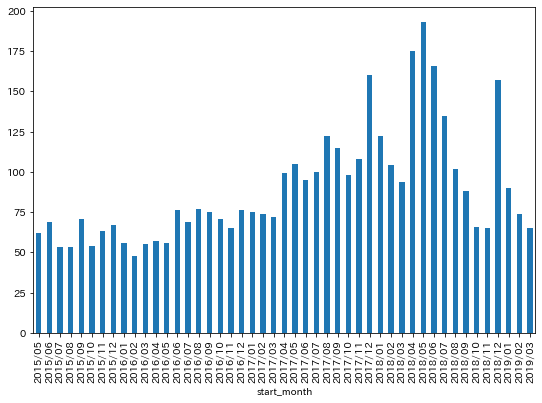

In [34]:
#月別の入会人数
from pylab import rcParams
rcParams['figure.figsize'] = 9,6
month_cus_graph = data2.groupby("start_month").count()["customer_id"]
month_cus_graph.plot.bar();
#2018年5月の入会人数は一番多い
#2016年2月の入会人数は一番少ない

In [35]:
#性別と利用会員区分
gender_class = data2.groupby(['gender', 'class']).count()[["customer_id"]]
gender_class

customer_id
gender class             
F      C01            822
       C02            835
       C03            326
M      C01           1223
       C02            184
       C03            802

In [36]:
pd.pivot_table(
    gender_class,
    index = 'class',
    columns = 'gender',
    values = [
        'customer_id'
    ],
    aggfunc = 'sum'
)

customer_id      
gender           F     M
class                   
C01            822  1223
C02            835   184
C03            326   802

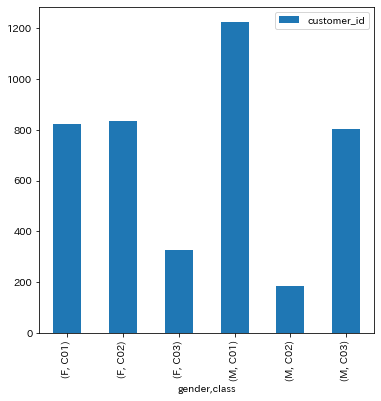

In [37]:
from pylab import rcParams
rcParams['figure.figsize'] = 6,6
gender_class.plot.bar();
#女性の中では日中だけ利用するデイタイム会員が多い
#男性の中ではいつでも利用できるオールタイム会員が多い、逆に日中だけ利用するデイタイム会員がとても少ない

## 2.最新会員情報のデータ分析

### A.最新会員情報のデータ分析

In [38]:
#退会済みの人、退会していない人の人数を確認
data2.groupby("is_deleted").count()["customer_id"]

is_deleted
0    2842
1    1350
Name: customer_id, dtype: int64

In [39]:
pd.set_option('display.max_rows',None)
print(data2.count())
per_user = (data2['customer_id'].count()-data2['end_date'].count())/data2['customer_id'].count()
per_user
per_end = 1-per_user
per_end

customer_id      4192
name             4192
class            4192
gender           4192
start_date       4192
end_date         1350
campaign_id      4192
is_deleted       4192
campaign_name    4192
class_name       4192
price            4192
start_year       4192
start_month      4192
dtype: int64


0.3220419847328244

In [40]:
#最新会員データの基礎集計を行う

data2["end_date"] = pd.to_datetime(data2["end_date"])

data3 = data2.loc[
    (data2["end_date"] >= pd.to_datetime("20190301"))|(data2["end_date"].isna())]
print(len(data3))

data3.head()

2953


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,campaign_name,class_name,price,start_year,start_month
0,as058623,宇野沙弥,C01,F,2015-05-01,NaT,CA1,0,通常,オールタイム,10500,2015,2015/05
1,as069821,小暮恵理,C03,F,2015-05-01,NaT,CA1,0,通常,ナイト,6000,2015,2015/05
2,as183155,益子涼花,C03,F,2015-05-01,NaT,CA1,0,通常,ナイト,6000,2015,2015/05
3,as476267,西口悠奈,C02,F,2015-05-01,NaT,CA1,0,通常,デイタイム,7500,2015,2015/05
4,as625883,石本真紗子,C02,F,2015-05-01,NaT,CA1,0,通常,デイタイム,7500,2015,2015/05


### B.データの欠損、データの揺れをチェック・補完する

In [41]:
pd.set_option('display.max_rows', None)
data3.dtypes

customer_id              object
name                     object
class                    object
gender                   object
start_date       datetime64[ns]
end_date         datetime64[ns]
campaign_id              object
is_deleted                int64
campaign_name            object
class_name               object
price                     int64
start_year               object
start_month              object
dtype: object

In [42]:
print(len(campaign_gym))
campaign_gym.isnull()

3


,campaign_id,campaign_name
0,False,False
1,False,False
2,False,False


In [43]:
campaign_gym

,campaign_id,campaign_name
0,CA1,通常
1,CA2,入会費半額
2,CA3,入会費無料


In [44]:
pd.set_option('display.max_rows', 4)
print(len(data3))
data3.isnull()

2953


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,campaign_name,class_name,price,start_year,start_month
0,False,False,False,False,False,True,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4190,False,False,False,False,False,True,False,False,False,False,False,False,False
4191,False,False,False,False,False,True,False,False,False,False,False,False,False


### C.最新会員データに対して会員区分別に人数を示す

In [45]:
data3.groupby("class_name").count()["customer_id"]

class_name
オールタイム    1444
デイタイム      696
ナイト        813
Name: customer_id, dtype: int64

### D.最新会員データに対してキャンペーン区分別に人数を示す

In [46]:
#最新入会費区分別に人数を確認
data3.groupby("campaign_name").count()["customer_id"]

campaign_name
入会費半額     311
入会費無料     242
通常       2400
Name: customer_id, dtype: int64

### E.最新会員データに対して性別人数を示す

In [47]:
#最新性別に人数を確認
data3.groupby("gender").count()["customer_id"]

gender
F    1400
M    1553
Name: customer_id, dtype: int64

### F.月別の入会人数を示す

In [48]:
#　月別
customer_year_new = data3.groupby(
   ['start_month']
).count()[
    ['name']
]
customer_year_new.head()

,name
start_month,
2015/05,62
2015/06,69
...,...
2015/08,53
2015/09,71


### G.在籍者と退会者の割合を示す

In [49]:
#在籍者と退会者の割合を示す
per_user = (data3['customer_id'].count()-data3['end_date'].count())/data3['customer_id'].count()
per_user
per_end = 1-per_user
per_end

0.03758889265154075

### H.データ検算をおこなう

In [50]:
print(len(data1))
print(len(data2))
print(len(data3))

4192
4192
2953


In [51]:
data1.isnull().sum()

customer_id      0
name             0
                ..
is_deleted       0
campaign_name    0
Length: 9, dtype: int64

In [52]:
data2.isnull().sum()

customer_id    0
name           0
              ..
start_year     0
start_month    0
Length: 13, dtype: int64

In [53]:
data3.isnull().sum()

customer_id    0
name           0
              ..
start_year     0
start_month    0
Length: 13, dtype: int64

### I.最新の会員データから読み取れることを調査する。

In [54]:
#退会した男女人数比率
F_M_deleted = data3.groupby("gender").count()["customer_id"] / data2.groupby("gender").count()["customer_id"]
F_M_deleted

gender
F    0.706001
M    0.703033
Name: customer_id, dtype: float64

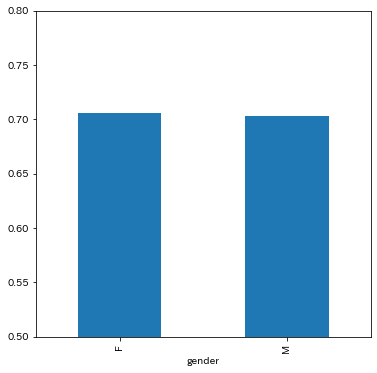

In [55]:
#男性退会する人は女性より多い
from pylab import rcParams
import matplotlib.pyplot as plt

plt.ylim(ymin = 0.5)
plt.ylim(ymax = 0.8)
rcParams['figure.figsize'] = 5,5

F_M_deleted.plot.bar();

In [56]:
#data2のキャンプーン区別人数
num_by_campaign = data2.groupby(['campaign_name']).count()[['customer_id']]
campaign_data2_data3 = num_by_campaign.rename(columns = {'customer_id':'data2_customer_id'})
campaign_data2_data3

,data2_customer_id
campaign_name,
入会費半額,650
入会費無料,492
通常,3050


In [57]:
#data2とdata3のキャンプーン区分別人数の比較
num3_by_campaign = data3.groupby("campaign_name").count()[["customer_id"]]
campaign_data2_data3['data3_customer_id'] = num3_by_campaign['customer_id']
campaign_data2_data3

,data2_customer_id,data3_customer_id
campaign_name,,
入会費半額,650,311
入会費無料,492,242
通常,3050,2400


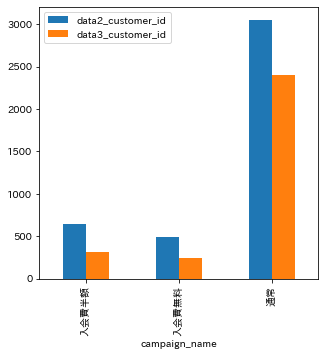

In [58]:
campaign_data2_data3.plot.bar();

In [59]:
campaign_data2_data3['is_deleted'] = campaign_data2_data3['data2_customer_id'] - campaign_data2_data3['data3_customer_id']
campaign_data2_data3

,data2_customer_id,data3_customer_id,is_deleted
campaign_name,,,
入会費半額,650,311,339
入会費無料,492,242,250
通常,3050,2400,650


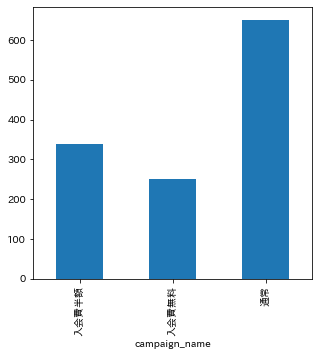

In [60]:
#通常料金で入会した人は退会するのが多い
campaign_data2_data3['is_deleted'].plot.bar();

In [61]:
data2['customer_id'] = data2['customer_id'].str.upper()
customer_use = pd.merge(
    use_log, data2,
    on='customer_id',
    how='left'
)
customer_use

,log_id,customer_id,usedate,name,class,gender,start_date,end_date,campaign_id,is_deleted,campaign_name,class_name,price,start_year,start_month
0,L00000049012330,AS009373,2018-04-01,中山光,C01,F,2015-11-01,NaT,CA1,0,通常,オールタイム,10500,2015,2015/11
1,L00000049012331,AS015315,2018-04-01,白木英紀,C01,M,2015-07-01,NaT,CA1,0,通常,オールタイム,10500,2015,2015/07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197426,L00000049209756,TS995853,2019-03-31,大城喜三郎,C01,M,2019-02-08,NaT,CA1,0,通常,オールタイム,10500,2019,2019/02
197427,L00000049209757,TS999079,2019-03-31,須賀修三,C03,M,2016-06-01,NaT,CA1,0,通常,ナイト,6000,2016,2016/06
